**Gene Recognition¶**

Gene Recognition System is a technology capable of matching a human face from a digital image or a video frame against a database of Gene, 

We'll be building a face recognition model that uses **Siamese Networks** to give us a distance value that indicates whether 2 images are same or different.

**The Dataset**

We'll be using the Extracted Gene from Gene-recognition-dataset, which is derived from Dataset. 

The dataset contains 1o94 different individuals, 
The images are of size (128,128,3) and are encoded in RGB.
Each folder and image is named with a number, i.e 0.jpg, 1.jpg

In [ ]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.9.2', '1.21.6')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r /content/datazip.zip "/content/drive/MyDrive/gene_name"

Scanning files ......
  adding: content/drive/MyDrive/gene_name/ (stored 0%)
  adding: content/drive/MyDrive/gene_name/986/ (stored 0%)
  adding: content/drive/MyDrive/gene_name/986/0.jpg (deflated 8%)
  adding: content/drive/MyDrive/gene_name/986/1.jpg (deflated 14%)
  adding: content/drive/MyDrive/gene_name/994/ (stored 0%)
  adding: content/drive/MyDrive/gene_name/994/1.jpg (deflated 15%)
  adding: content/drive/MyDrive/gene_name/994/0.jpg (deflated 11%)
  adding: content/drive/MyDrive/gene_name/984/ (stored 0%)
  adding: content/drive/MyDrive/gene_name/984/0.jpg (deflated 9%)
  adding: content/drive/MyDrive/gene_name/984/1.jpg (deflated 14%)
  adding: content/drive/MyDrive/gene_name/995/ (stored 0%)
  adding: content/drive/MyDrive/gene_name/995/2.jpg (deflated 17%)
  adding: content/drive/MyDrive/gene_name/995/0.jpg (deflated 14%)
  adding: content/drive/MyDrive/gene_name/995/1.jpg (deflated 14%)
  adding: content/drive/MyDrive/gene_name/995/3.jpg (deflated 17%)
  adding: content/d

In [ ]:
!unzip /content/datazip.zip

Archive:  /content/datazip.zip
replace content/drive/MyDrive/gene_name/986/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: content/drive/MyDrive/gene_name/986/0.jpg  
  inflating: content/drive/MyDrive/gene_name/986/1.jpg  
  inflating: content/drive/MyDrive/gene_name/994/1.jpg  
  inflating: content/drive/MyDrive/gene_name/994/0.jpg  
  inflating: content/drive/MyDrive/gene_name/984/0.jpg  
  inflating: content/drive/MyDrive/gene_name/984/1.jpg  
  inflating: content/drive/MyDrive/gene_name/995/2.jpg  
  inflating: content/drive/MyDrive/gene_name/995/0.jpg  
  inflating: content/drive/MyDrive/gene_name/995/1.jpg  
  inflating: content/drive/MyDrive/gene_name/995/3.jpg  
  inflating: content/drive/MyDrive/gene_name/977/1.jpg  
  inflating: content/drive/MyDrive/gene_name/977/0.jpg  
  inflating: content/drive/MyDrive/gene_name/99/0.jpg  
  inflating: content/drive/MyDrive/gene_name/99/6.jpg  
  inflating: content/drive/MyDrive/gene_name/99/1.jpg  
  inflating: content/dri

In [ ]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "/content/drive/MyDrive/gene_name"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image =cv2.resize(image,(128,128))
    return image

In [ ]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 426
Length of testing list : 48

Test List: {'984': 2, '986': 2, '790': 2, '799': 2, '447': 4, '137': 2, '325': 3, '781': 2, '881': 2, '19': 2, '199': 7, '742': 2, '518': 2, '205': 16, '717': 2, '629': 10, '493': 2, '695': 2, '232': 2, '978': 2, '109': 106, '352': 2, '820': 3, '38': 61, '514': 2, '661': 2, '133': 19, '417': 6, '519': 3, '840': 7, '754': 3, '92': 2, '3': 8, '66': 2, '208': 2, '441': 2, '1072': 7, '970': 2, '385': 2, '293': 2, '239': 2, '140': 9, '26': 3, '197': 13, '544': 6, '227': 4, '653': 3, '315': 3}


Creating Batch-Generator

Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

Batch_size: Batch_size of the data to return

Preprocess: Whether to preprocess the data or not

In [ ]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [ ]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 5142
Number of testing triplets : 486

Examples of triplets:
(('193', '0.jpg'), ('193', '5.jpg'), ('536', '1.jpg'))
(('378', '3.jpg'), ('378', '9.jpg'), ('581', '1.jpg'))
(('72', '7.jpg'), ('72', '9.jpg'), ('883', '1.jpg'))
(('9', '1.jpg'), ('9', '2.jpg'), ('603', '2.jpg'))
(('378', '1.jpg'), ('378', '9.jpg'), ('144', '0.jpg'))


### Creating Batch-Generator

the development of a "Batch-Generator" that "preprocesses" the triplets supplied into batches of gene data before providing the data in separate lists.

**Parameters:**
- Batch size: Size of the batch of data to be returned.
- Preprocess: The decision of whether to preprocess the data.


In [ ]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

### Plotting the Data

Using a plot to display the data produced by **get batch()**

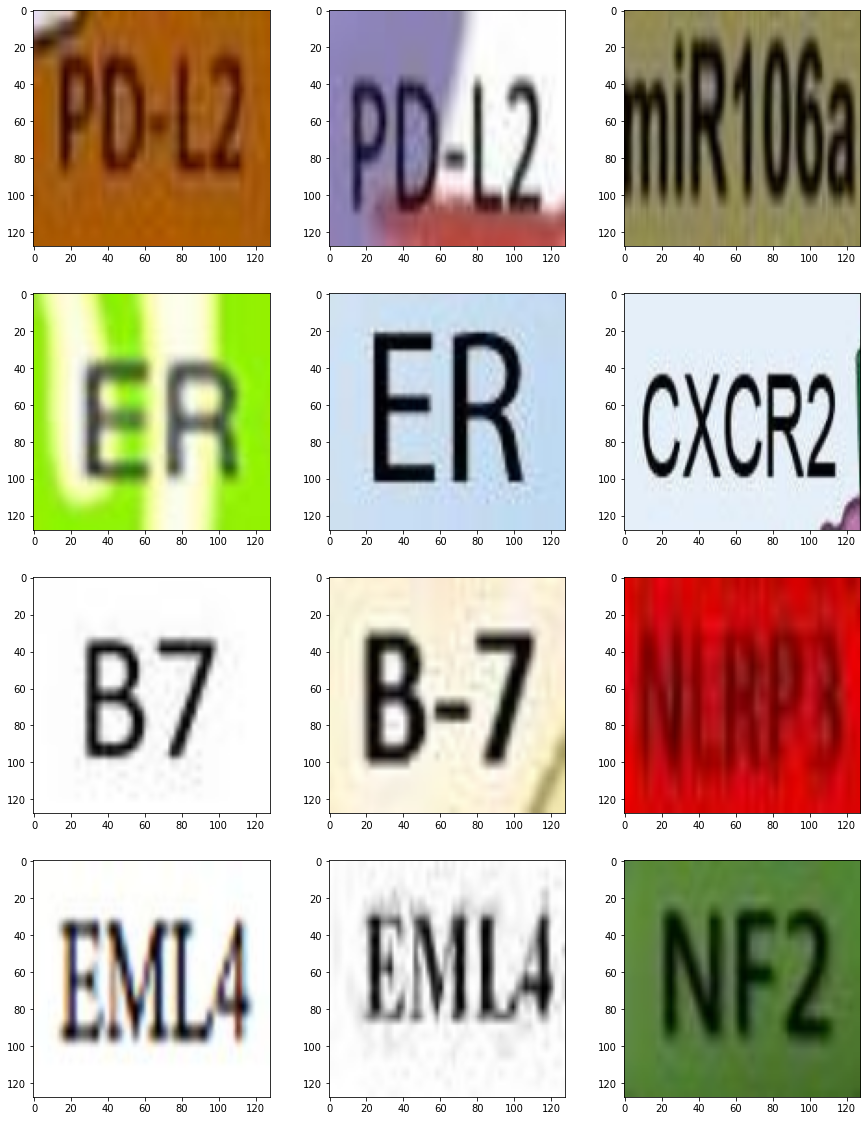

In [ ]:
num_plots = 4

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

Creating the Model

Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

In [ ]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Encoder

The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

### Siamese Network

We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:
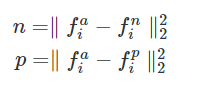


In [ ]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                   

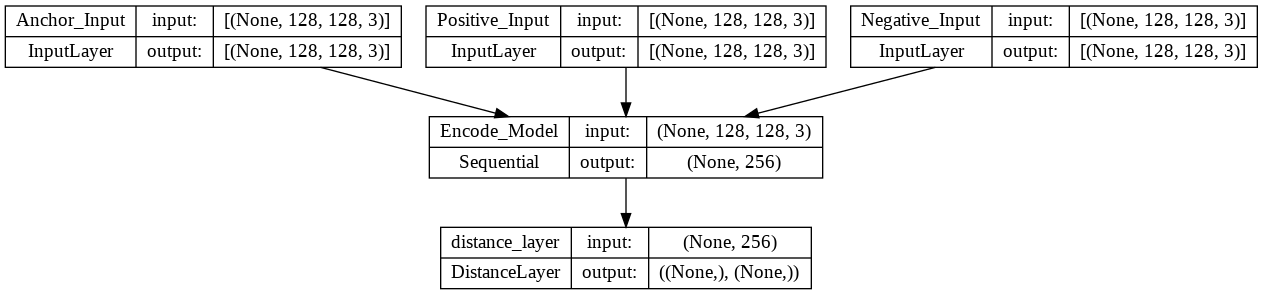

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

### Putting everything together

We now need to implement a model with custom training loop and loss function so we can compute the **triplet loss** using the three embeddings produced by the Siamese network.

We'll create a **Mean metric** instance to track the loss of the training process.

**Triplet Loss Function:**

<img src="https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png" alt="Loss Formula" width="400"/>

In [ ]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## **Training the Model**
The siamese model will now be trained using batches of triplets. The training loss and extra metrics from testing for each epoch will be printed. Every time the model performs better than the previous max accuracy, the model weights are also recorded.

In order to assess how to improve the model's accuracy, we hope to gather more metrics about it. The epochs have been set in order to adhere to Kaggle's time limit.

### Test Function 

The function **test on triplets()** is in charge of testing the model on test triplets. By making predictions based on the train data, it will gather metrics (accuracy, means, and standards). After testing, we'll additionally print the model's Accuracy.

In [ ]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
save_all = False
epochs = 50
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []

    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 77 sec)
Loss on train    = 0.51879
4/4 [==============================] - 3s 339ms/step
Accuracy on test = 0.88066

EPOCH: 2 	 (Epoch done in 54 sec)
Loss on train    = 0.25004
4/4 [==============================] - 0s 116ms/step
Accuracy on test = 0.90123

EPOCH: 3 	 (Epoch done in 54 sec)
Loss on train    = 0.15936
4/4 [==============================] - 0s 118ms/step
Accuracy on test = 0.90947

EPOCH: 4 	 (Epoch done in 54 sec)
Loss on train    = 0.09721
4/4 [==============================] - 0s 119ms/step
Accuracy on test = 0.90741

EPOCH: 5 	 (Epoch done in 56 sec)
Loss on train    = 0.06941
4/4 [==============================] - 0s 121ms/step
Accuracy on test = 0.92387

EPOCH: 6 	 (Epoch done in 53 sec)
Loss on train    = 0.05651
4/4 [==============================] - 0s 118ms/step
Accuracy on test = 0.87860

EPOCH: 7 	 (Epoch done in 55 sec)
Loss on train    = 0.05420
4/4 [==============================] - 0s 117ms/step
Accuracy on test = 0.88066

EPOCH

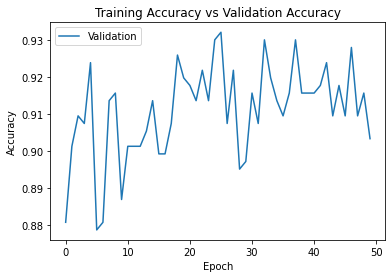

In [ ]:
#plt.plot(train_loss)
acc = []
for x in test_metrics:
  acc.append(x[0])
plt.plot(acc)
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['Train', 'Validation'], loc='upper left')
plt.legend(['Validation'], loc='upper left')
plt.show()

Evaluating the Model

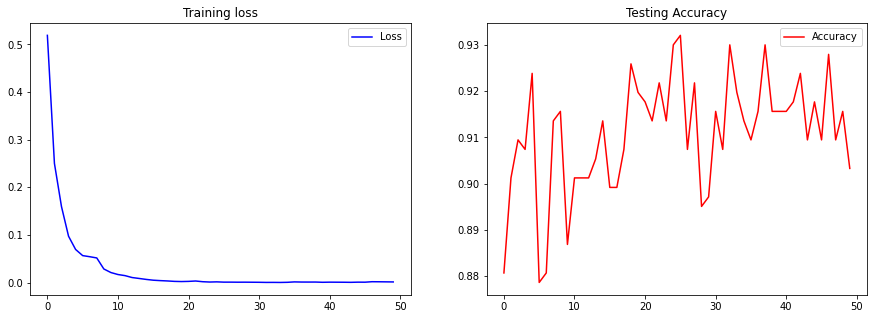

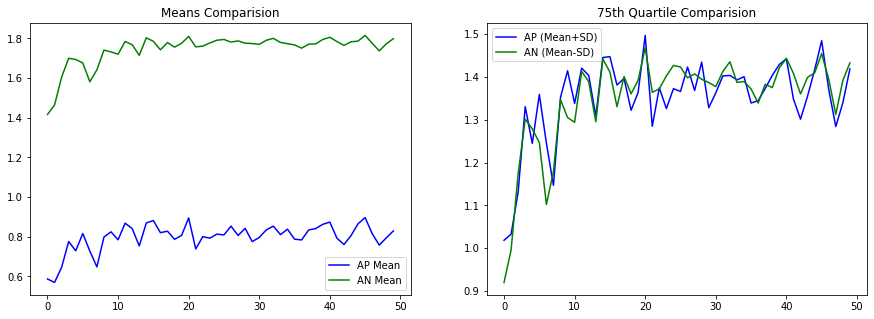

In [ ]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

Using the Model

Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for latter use.

In [ ]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_14 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 lambda_2 (Lambda)           (None, 256)               0         
                                                      

Classify Images¶

To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

8/8 [==============================] - 0s 37ms/step

Accuracy of model: 0.826171875



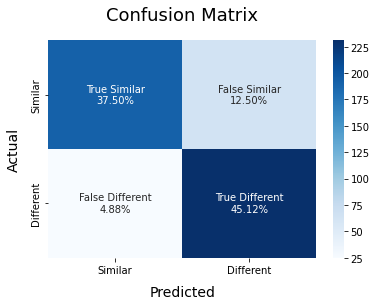

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

Finally, we can compute the cosine similarity between the anchor and positive images and compare it with the similarity between the anchor and the negative images.

We should expect the similarity between the anchor and positive images to be larger than the similarity between the anchor and the negative images.

In [ ]:
train_anchor = []
train_pos = []
train_neg = []
for x in train_triplet:
  a, p, n = x
  train_anchor.append(read_image(a))
  train_pos.append(read_image(p))
  train_neg.append(read_image(n))

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(train_anchor, train_pos)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(train_anchor, train_neg)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9449776
Negative similarity 0.9410476


In [ ]:
test_anchor = []
test_pos = []
test_neg = []
for x in test_triplet:
  a, p, n = x
  test_anchor.append(read_image(a))
  test_pos.append(read_image(p))
  test_neg.append(read_image(n))

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(test_anchor, test_pos)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(test_anchor, test_neg)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.95397836
Negative similarity 0.9464412
